# Solar Position

This notebook demonstrates several aspects of the solar zenith angles returned from the API:

1) The solar position algorithm used by the API is equivalent to pvlib's implementation of the SPA to within the precision of the values returned from the API (2 digits after the decimal).
2) The solar zenith angle returned from the API is refraction-corrected.
3) The refraction correction uses time-varying ambient temperature and pressure, not annual averages as prescribed in the original SPA reference.
4) The solar zenith angle returned from the API is calculated for the center of the PSM3 pixel.

In [156]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
# fetch an example PSM3 dataset
df, meta = pvlib.iotools.get_psm3(40.00, -80.01,
                                  api_key='DEMO_KEY', email='assessingsolar@gmail.com',
                                  names=2020, interval=5, map_variables=True, leap_day=True,
                                  attributes=['solar_zenith_angle', 'air_temperature', 'surface_pressure'])

df['pressure'] = df['pressure'] * 100  # mbar to Pa

First, let's determine whether the zenith angles are corrected for atmospheric refraction.  Refraction correction as modeled in the SPA manifests as a small jump on the order of half a degree when the zenith crosses the horizon.  Indeed we observe such a jump in the values returned from the API:

Text(0, 0.5, 'PSM3 Solar Zenith [degrees]')

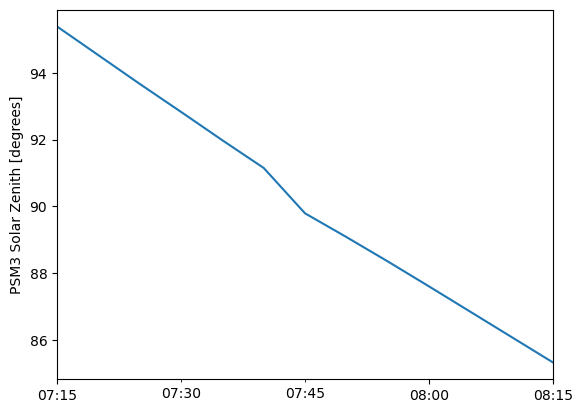

In [141]:
df.loc['2020-01-01 07:15':'2020-01-01 08:15', 'solar_zenith'].plot()
plt.ylabel('PSM3 Solar Zenith [degrees]')

Now, let's show two things at once: first, that the refraction correction uses time-varying temperature and pressure (as opposed to annual averages as in the original SPA reference), and second, that both the underlying geometric solar position and the refraction correction are exactly consistent with pvlib's SPA implementation.  Note that, because the API values are rounded to 2 decimal places, we can only expect agreement to $\pm 0.005°$.

In [116]:
kwargs = dict(time=df.index, latitude=40.00, longitude=-80.01, altitude=meta['altitude'])

sp1 = pvlib.solarposition.spa_python(**kwargs, temperature=df['temp_air'].mean(), pressure=df['pressure'].mean())
sp2 = pvlib.solarposition.spa_python(**kwargs, temperature=df['temp_air'], pressure=df['pressure'])

annual average temperature/pressure - 1st and 99th percentiles: [-0.01106459  0.00836248]
time series temperature/pressure - 1st and 99th percentiles: [-0.00489857  0.00491025]


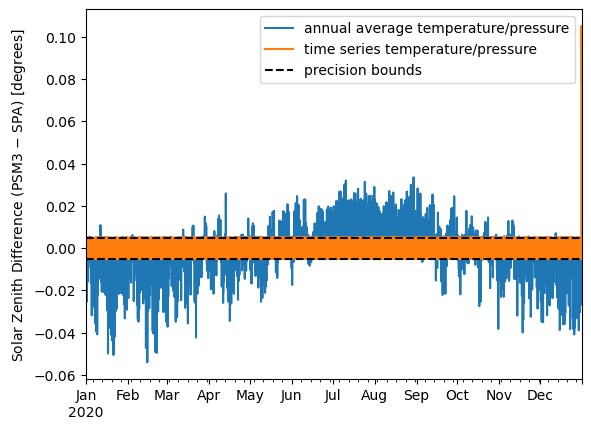

In [153]:
for case, sp in [('annual average temperature/pressure', sp1), ('time series temperature/pressure', sp2)]:
    aux = pd.DataFrame({'psm3': df['solar_zenith'], 'spa': sp['apparent_zenith']})
    aux['diff'] = aux['psm3'] - aux['spa']
    aux['diff'].plot(label=case)
    print(case, '- 1st and 99th percentiles:', aux['diff'].quantile([0.01, 0.99]).values)

plt.ylabel('Solar Zenith Difference (PSM3 $-$ SPA) [degrees]')
plt.axhline(+0.005, ls='--', c='k', label='precision bounds')
plt.legend()
plt.axhline(-0.005, ls='--', c='k');

Attentive readers may notice that the last few hours of the year have much larger error than the rest.  This is due to the "roll-over" effect described in [End-of-year “roll-over”](rollover.ipynb).  Let's correct for that:

In [162]:
# mimic the PSM3 "roll-over" effect
is_rolled = df.index > (df.index[-1] + df.index[-1].utcoffset())
df_shift = df.copy()
df_shift.index = np.where(is_rolled, df_shift.index - pd.DateOffset(years=1), df_shift.index)

sp3 = pvlib.solarposition.spa_python(df_shift.index, meta['latitude'], meta['longitude'], meta['altitude'],
                                     pressure=df_shift['pressure'], temperature=df_shift['temp_air'])

# finally, re-roll the index back to PSM3's weird index so we can compare with the API data
sp3.index = df.index

# Now we see that correcting for the roll-over effect brings the error
# down to the +/- 0.005 degree precision limit for the entire year:
difference = pd.DataFrame({
    'difference without correcting rollover': sp2['apparent_zenith'],
    'difference corrected for rollover': sp3['apparent_zenith'],
}).subtract(df['solar_zenith'], axis=0)

difference.describe().loc[['min', 'max']].round(3)

,difference without correcting rollover,difference corrected for rollover
min,-0.105,-0.005
max,0.005,0.005


Finally, let's show that the solar position is indeed calculated for the center of the pixel by showing that the error exceeds the $\pm 0.005°$ threshold when calculating position for other locations in the pixel. Note also the large excursions beyond the main noise region; these are caused by the discontinuous nature of the SPA's refraction correction combined with disagreement about whether the sun is slightly above or slightly below the horizon.

1st and 99th percentiles: [-0.01038933  0.01043635]


(-0.05, 0.05)

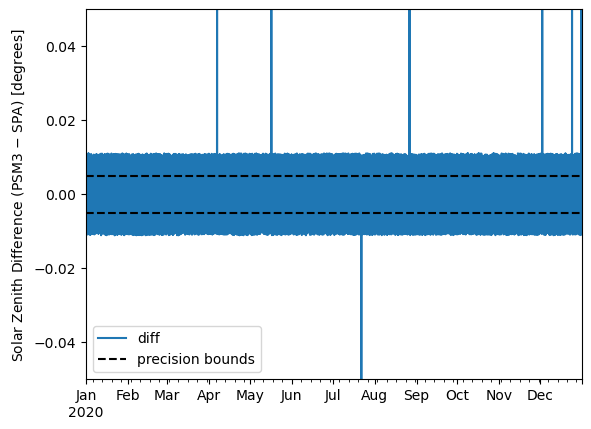

In [154]:
sp3 = pvlib.solarposition.spa_python(df.index, 40.00, -80.018, altitude=meta['altitude'], temperature=df['temp_air'], pressure=df['pressure'])

aux = pd.DataFrame({'psm3': df['solar_zenith'], 'spa': sp3['apparent_zenith']})
aux['diff'] = aux['psm3'] - aux['spa']
aux['diff'].plot()
print('1st and 99th percentiles:', aux['diff'].quantile([0.01, 0.99]).values)

plt.ylabel('Solar Zenith Difference (PSM3 $-$ SPA) [degrees]')
plt.axhline(+0.005, ls='--', c='k', label='precision bounds')
plt.legend()
plt.axhline(-0.005, ls='--', c='k')
plt.ylim(-0.05, 0.05)

In [163]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2022-09-21 18:07:18

pvlib     : 0.9.3
numpy     : 1.22.3
matplotlib: 3.5.2
pandas    : 1.5.0

